# MCMC for the mass distribution of EMRIs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns


%matplotlib inline
np.random.seed(1234)


params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

We fit a BH mass functionsource parameter given by the mass, $\theta=M$. This example follows the EMRI mass function [e-Print: 1004.1921 ("GTV")]:

$$\frac{dN}{d\ln M}=A_0\big(\frac{M}{M_*}\big)^{\alpha_0} \quad\Rightarrow\quad p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}.$$

We are interested in the $ \lambda=\alpha_0$ population parameter. We are assuming that the amplitude $A_0$ does not carry information about the system, but only about the rate of events.

In [2]:
"""
Parameters
"""

N_obs = 100
N_samp_per_obs = 10

# Inputs to get the true ln M distribution.
# Notice that M runs from 10^4 to 10^7 in GTV.

alpha0_t = 0.00001 # Choose flat spectral profile.
M_min=10000. ;   logM_min = np.log(M_min)
M_max=10000000.; logM_max = np.log(M_max)

In [3]:
def model(lnM,alpha):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data    (The noisy generated data where we expect the masses to be.)
    - alpha   (Spectral index of the mass distribution.)
    
    """
    
    M = np.exp(lnM) # mass observations
    norm  = alpha/(M_max**alpha-M_min**alpha)
    
    
    return norm*M**(alpha-1)

The hyperlikelihood is (with $\theta = \ln M$ and $\lambda=\alpha$):

$$
p(d|\lambda) = \prod_{i=1}^{N_\text{obs}} p(d_i|\lambda) = \prod_{i=1}^{N_\text{obs}} \int p(d_i|\theta_i)p_\text{pop}(\theta_i|\lambda) d\theta_i,
$$

which can be rearranged through Bayes theorem to give

$$
    p(d|\lambda) = \prod_{i=1}^{N_\text{obs}} \int \frac{p(\theta_i|d_i) p(\theta_i)}{p(d_i)}p_\text{pop}(\theta_i|\lambda) d\theta_i.
$$

The integral can be solved with Monte Carlo methods drawing $N_\text{samp}$ samples from the posterior, $\theta_{ij}\sim p(\theta_{i}|d_i)$ ($j$ indexing the samples),

$$
   p(d|\lambda) = \prod_{i=1}^{N_\text{obs}} \frac{1}{N_\text{samp}}\sum_{j=1}^{N_\text{samp}} \frac{p(\theta_{ij})}{p(d_i)}p_\text{pop}(\theta_{ij}|\lambda)\quad \Rightarrow \quad \log p(d|\lambda)\propto \sum_{i=1}^{N_\text{obs}}\sum_{j=1}^{N_\text{samp}} p_\text{pop}(\theta_{ij}|\lambda)\equiv \sum_{i=1}^{N_\text{obs}}\sum_{j=1}^{N_\text{samp}} p_{\text{pop},ij}.
$$

In the last line, we ignore normalization factors and take the log of the hyperlikelihood. The final expression is coded up below.


Starting from the probability density $p(M|\lambda)=\mathcal{N} M^{\alpha_0-1}$, we can use the method of inversion to get the source parameter M. In particular, we define the cumulative density function,

$u:=\text{CDF}(M)= \mathcal{N}\int_{M_\text{min}}^{M}M^{\alpha_0-1}dM = \alpha_0^{-1}\mathcal{N}M^{\alpha_0}\big|_{M_\text{min}}^{M}=\alpha_0^{-1}\mathcal{N}(M^{\alpha_0}-M^{\alpha_0}_{\text{min}})$.

The normalization factor can be calculated imposing that $\lim_{M\rightarrow M_{\text{min}}} u=1$, which gives immediately:

$\mathcal{N}=\frac{\alpha_0}{M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}}}$.

Now, we get M in terms of $u$, 

$\quad M^{\alpha_0}=\alpha_0\mathcal{N}^{-1} u +M^{\alpha_0}_{\text{min}}\quad\Longrightarrow \quad \ln M =\frac{1}{\alpha_0} \ln\big[(M^{\alpha_0}_\text{max}-M^{\alpha_0}_{\text{min}})\, u +M^{\alpha_0}_{\text{min}}\big]\quad $ (true parameter distribution).

In [4]:
from scipy.special import erfc

sigma = 0.1
dth = 13.0
noise = np.random.normal(0,sigma,size = N_obs)

"""
Data draws.
"""

u = np.random.uniform(size=N_obs)
logM_t=alpha0_t**-1 * np.log((M_max**(alpha0_t)-M_min**(alpha0_t))*u+ M_min**(alpha0_t)*np.ones(N_obs))
#logM_obs = 0.5 * erfc((dth - logM_t)/np.sqrt(2*sigma**2))


d_i = noise + logM_t  # observation model made of noise + true population.

d_i_selbias = d_i[d_i>dth]
N_det = len(d_i_selbias)

"""
Data array. The structure of data is such that Data[i,j] is the jth posterior sample from event i.
We assume the observation model p(d|theta) is a normal gaussian.

"""

logM_obs=np.zeros((N_obs,N_samp_per_obs))
logM_obs_selbias=np.zeros((N_det,N_samp_per_obs))

for i in np.arange(N_obs):
    logM_obs[i,:]=np.random.normal(d_i[i],sigma,size=N_samp_per_obs)
    
for i in np.arange(N_det):
    logM_obs_selbias[i,:]=np.random.normal(d_i_selbias[i],sigma,size=N_samp_per_obs)

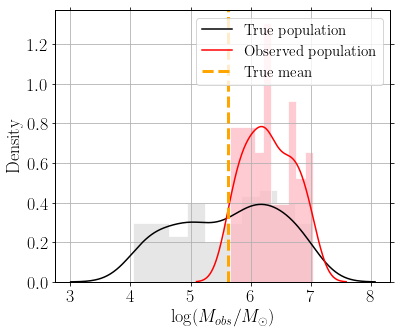

In [5]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plt.hist(np.log10(np.exp(d_i)),density=True,bins=10,histtype = 'stepfilled',
                               color ='gainsboro', alpha=0.7, edgecolor='white')
plt.hist(np.log10(np.exp(d_i_selbias)),density=True,bins=10,histtype = 'stepfilled',
                               color ='lightpink', alpha=0.7, edgecolor='white')
sns.kdeplot(np.array(np.log10(np.exp(d_i))), label='True population',c='k')
sns.kdeplot(np.array(np.log10(np.exp(d_i_selbias))), label='Observed population',c='red')
plt.axvline(x=np.log10(np.exp(np.mean(logM_t))), label='True mean', c='orange',ls='--',lw=3)

plt.xlabel('$\log(M_{obs}/M_\odot)$')
plt.ylabel('Density')
plt.legend()

In [6]:
# Limits of (flat) hyperpriors.

hyperprior_min = -10.0
hyperprior_max = 10.0

def log_likelihood(params, data):
    
     
    support = ( # Here is the support limits for hyperpriors.
                (params[0] >= hyperprior_min)&
                (params[0] <= hyperprior_max)
                )
    
    log_likelihood=0
    
    for i in np.arange(N_obs):
        
        ppop_ij = model(data[i,:],params[0])        # N_samp-long array for population model.
        sum_ppop = np.sum(ppop_ij)                  # internal sum of population model over N_samp.
        log_likelihood += np.log(sum_ppop)          # add the samples drawn over N_obs in the loop.
        
    out = np.where(support,log_likelihood,-np.inf)  # Only retain likelihood if supported.
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf


    
def log_M(alpha, N, Mmax,Mmin):

    
    
    return alpha**-1 * np.log((Mmax**(alpha)-Mmin**(alpha))*np.random.uniform(size=N)+ Mmin**(alpha)*np.ones(N))


def log_likelihood_selbias(params, data):
    
     
    support = ( # Here is the support limits for hyperpriors.
                (params[0] >= hyperprior_min)&
                (params[0] <= hyperprior_max)
                )
    
    log_likelihood=0

    N_MC = 100*N_obs#100000
    theta_ij = log_M(params[0],N_MC, M_max,M_min) #from p(theta|lambda)
    pdet = np.sum(0.5*erfc((dth-theta_ij)/np.sqrt(2)/sigma))
    if (pdet < 1.):
        pdet=1.
    #pdet=1

    for i in np.arange(N_det):
        
        
       #pdet = 1.0
        ppop_ij = model(data[i,:],params[0])           # N_samp-long array for population model.
        sum_ppop = np.sum(ppop_ij)                     # internal sum of population model over N_samp.
        log_likelihood += np.log(sum_ppop/pdet)        # add the samples drawn over N_obs in the loop.
        
    out = np.where(support,log_likelihood,-np.inf)     # Only retain likelihood if supported.
    
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

In [7]:
#N_MC = 1000
#for i in np.arange(100):
#    alpha=-2.+0.04*i
 #   theta_ij = log_M(alpha,N_MC, M_max,M_min) #from p(theta|lambda)
  #  pdet = np.sum(0.5*erfc(-(theta_ij-dth)/np.sqrt(2)/sigma))
   # print(alpha,pdet)

In [8]:
"""
Choose which data and likelihood.
"""

which_likelihood = log_likelihood_selbias  #log_likelihood
which_data = logM_obs_selbias #logM_obs

In [9]:
n_iter = 10000
ndim = 1; nwalkers = 2

pos_init0 = [alpha0_t]
p0 = pos_init0*(1+0.001* np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, which_likelihood, args=[which_data])

sampler.run_mcmc(p0, n_iter, progress=True)

100%|██████████| 10000/10000 [00:20<00:00, 493.13it/s]


State([[-0.08499213]
 [ 0.29596965]], log_prob=[-1241.02130539 -1243.4121568 ], blobs=None, random_state=('MT19937', array([2209347806, 1455763380,  709510636, 3440843077, 3752617489,
        952088491,  775820782, 3265816795, 2607858076, 2131653488,
        367262757,   69774036, 2471148712,  334551069, 2530767509,
       3778372721, 2232825961, 2484599706,  536755321, 1726053193,
       1405787848, 1403658940, 1058375347, 3711841685, 1464080188,
       4088532797,  521907408, 2551004495,  508623852, 1870710050,
       1507605330, 1357887546, 1662696059,  487750145, 2972828509,
       4127227867, 2933099517, 3169747188, 3396143777, 2543587073,
        177375178, 2909857872, 1445229585, 2815489797, 2083182109,
        997998635, 3615565821, 2455040128,  523563430, 1172772658,
        342667079,   72367162, 1542499455,  622308796,  699108808,
       4186053107,  852556511,  760193008,    8451847, 1700102640,
       1797000450, 4162255694, 3043794009, 1781440522, 2423510124,
       39729

In [10]:
"""
Collect the samples here.
"""
burnin = 1500

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
alpha_samples = chains[:,:,0].flatten()

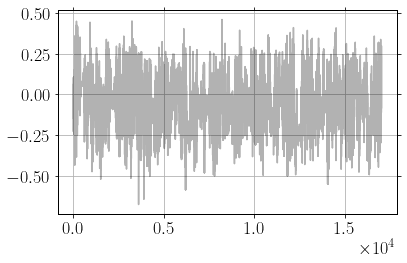

In [11]:
plt.plot(alpha_samples, "k", alpha=0.3)
plt.tight_layout()
plt.show()

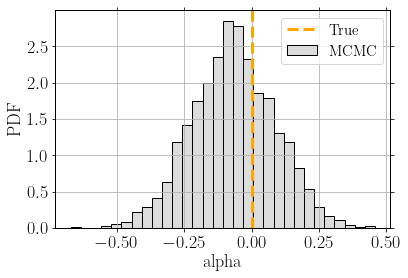

In [12]:
"""
Posteriors with Fisher estimates
"""


_, bins_alpha, _= plt.hist(alpha_samples, 30, histtype = 'bar',
                               color ='gainsboro', density=True, edgecolor='black', label='MCMC')


plt.axvline(x=alpha0_t, label='True', c='orange',ls='--',lw=3)
plt.xlabel('alpha')
plt.ylabel('PDF')
plt.legend()
plt.show()